In [1]:
using Pkg
Pkg.add("Interpolations")
Pkg.add("BasicInterpolators")

    Updating registry at `C:\Users\Miguel\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Miguel\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Miguel\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Miguel\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Miguel\.julia\environments\v1.9\Manifest.toml`


# We solve for stratified atmosphere
Given that $\vec{q}=\nabla(\tau)$ and $\vec{w}$ is the wind velocity, for a stratified atmosphere we obtain $$\dfrac{dq_x}{dt}=\dfrac{dq_y}{dt}=0;\dfrac{dq_z}{dt}=-q\dfrac{\partial c}{\partial z}-\vec{q}.\dfrac{\partial \vec{w}}{\partial z}$$ (Brouwer 2014).

We implement a case of constant wind speed ($\dfrac{\partial \vec{w}}{\partial z}$) with sound speed dependent on the height with the temperature: $$c_{air}=331 \dfrac{m}{s}\sqrt{\dfrac{T_{z=0m}-\dfrac{z}{300m}}{273.15 K}}$$

We obtain: $$\dfrac{dq_z}{dt}=-\sqrt{q_x^2+q_y^2+q_z^2}\dfrac{\partial c}{\partial z}; \dfrac{\partial c}{\partial z}=-\dfrac{331}{600*273.15\sqrt{\dfrac{T_{z=0m}-\dfrac{z}{300m}}{273.15 K}}}=- \dfrac{331^2}{600*273.15*c(T,z)}\dfrac{1}{s} \Rightarrow \dfrac{dq_z}{dt}=\dfrac{1}{q_z}\dfrac{dq_z}{dz}=\dfrac{331^2\sqrt{q_{x}^2+q_{y}^2+q_z^2}}{600*273.15*c(T,z)} \Rightarrow \dfrac{dq_z}{dz}=\dfrac{331^2\sqrt{q_{x}^2+q_{y}^2+q_z^2}q_z}{600*273.15*c(T,z)}$$

With $$\dfrac{dt}{d\tau}=1$$ and the initial condition $$\tau(x,y,z=Source)=0$$ we obtain $$\tau=| \int \vec{q} d \vec{s} | \approx \Sigma |\vec{q_i}.\vec{\Delta {s_i}}  |$$ being s each differential element of the path traveled by the acoustic ray.


In [6]:
#Altitude dependent temperature
function c_air_TZ(T_z0,z)
    c_air=331*sqrt((T_z0+273.15-z/300)/273.15) # T_Z0 is entered in Celsius for convenience
    return c_air
end

c_air_TZ (generic function with 1 method)

We solve the ODE system: $\dfrac{dq_x}{dz}=\dfrac{dq_y}{dz}=0 ;\dfrac{dq_z}{dz}=\dfrac{331^2\sqrt{q_{x}^2+q_{y}^2+q_z^2}q_z}{600*273.15*c(T,z)}$

In [7]:
@time begin
#############################################
using DifferentialEquations

#Arguments and data
v_wind=[5.,-10,-5.];
T=20.;  
SourcePoint=[0.,0.,0.];
ReceiverPoint=[5000.,5000.,5000.];

# We define the ODE
    function q!(dq, q, p, z)
        c=c_air_TZ(p[1],z)
        dq[1]=0
        dq[2]=0
        dq[3] = 331^2*sqrt(q[1]^2 + q[2]^2 + q[3]^2)*q[3] / (600 * 273.15 *c)
    end
    theta=rad2deg(acos(1/sqrt(3)))
    phi=45 # Calculated both directly.
    # We define the initial conditions and parameters.
    q0=1/(c_air_TZ(T, SourcePoint[3])+(v_wind[1]*cosd(phi)+v_wind[2]*sind(phi))*sind(theta))
    q_x = q0*cosd(phi)*sind(theta)
    q_y = q0*sind(phi)*sind(theta)
    q_z = q0*cosd(theta)
    u0 = [q_x, q_y, q_z]

    # We define the range of z values. We must be careful when optimizing, given
    # that if any optimized value (z coordinate) is outside of zspan we cannot evaluate it.
    zspan = (SourcePoint[3], ReceiverPoint[3])

    # We define the parameters.
    p = [T] 

    # We define the ODE problem.
    prob = ODEProblem(q!, u0, zspan, p)
    
    # We solve the ODE problem storing in the Z values that correspond to the intersections of the segments.
    sol = solve(prob, RK4(),dt=1e-3)
    
    # We save the values of vec(q)
    qx_vals=zeros(length(sol.u))
    qy_vals=zeros(length(sol.u))
    qz_vals=zeros(length(sol.u))

    for i in 1:length(sol.u)
        qx_vals[i]=sol.u[i][1]
        qy_vals[i]=sol.u[i][2]
        qz_vals[i]=sol.u[i][3]
    end
#########################
end

  0.255311 seconds (92.58 k allocations: 6.270 MiB, 99.29% compilation time: 96% of which was recompilation)


In [8]:
#Interpolate
using Interpolations
###### qx and qy are constants
qx=sum(qx_vals)/length(qx_vals)
######
qy=sum(qy_vals)/length(qy_vals)
######
z_values_linear = collect(range(SourcePoint[3], stop=ReceiverPoint[3], length=length(qz_vals)))
qz_z_linear=LinearInterpolation(z_values_linear, qz_vals)




9-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0016980037155087805
 0.0016980037252445233
 0.001698003822601959
 0.0016980047961770292
 0.001698014531999111
 0.001698111897358504
 0.0016990862654346487
 0.00170890202527781
 0.0017483714615856465

In [9]:
using DifferentialEquations

function Hamiltonian_l(qx::Float64,qy::Float64,qz_z_linear, SegmentsCoords::Array{Float64, 2})
   
    # We calculate the travel time between each segment taking the average of the q's between each segment 
    #(Trapezoid rule approximation)
    taus=zeros(length(SegmentsCoords[:,1])-1)
    for i in 1:(length(SegmentsCoords[:,1])-1)
        # qx and qy are constants, it doesn't matter which element of the vector we take.
        aux_x=(SegmentsCoords[i+1,1]-SegmentsCoords[i,1])
        aux_y=(SegmentsCoords[i+1,2]-SegmentsCoords[i,2])
        #The cubic interpolation function can extrapolate slightly outside the data range
        # due to the nature of cubic interpolation. Iterating the initial condition leads to BoundsError. 
        #We must use  clamp() to ensure it interpolates within the range.
        z1 = clamp(SegmentsCoords[i,3], SegmentsCoords[1,3], SegmentsCoords[end,3])
        z2 = clamp(SegmentsCoords[i+1,3], SegmentsCoords[1,3], SegmentsCoords[end,3])
        aux_z=(SegmentsCoords[i+1,3]-SegmentsCoords[i,3])
        q_m=sqrt(qx^2+qy^2+(qz_z_linear(z1)+qz_z_linear(z2))^2/4)
        taus[i]=q_m*sqrt(aux_x^2+aux_y^2+aux_z^2)
    end
    
    # We add up the traveltime of each segment to get the total.
    total_travel_time = sum(taus)
        
    return total_travel_time
end

Hamiltonian_l (generic function with 1 method)

In [10]:
@time begin
using Optim

# Arguments and data
v_wind=[5.,-10,-5.];
T=20.;  
SourcePoint=[0.,0.,0.];
ReceiverPoint=[5000.,5000.,5000.];

#We optimize the coordinates of the intersections between segments.
function objective(SegmentsCoords)
    # # First, we make sure that SourcePoint and ReceiverPoint are not optimized but are included in SegmentsCoords
    FullSegmentsCoords = vcat(reshape(SourcePoint, 1, :), SegmentsCoords, reshape(ReceiverPoint, 1, :))
    traveltime = Hamiltonian_l(qx, qy, qz_z_linear, FullSegmentsCoords)
    return traveltime
end

# Piecewise straight line from the source to the receiver as initial condition.
num_segments=10;
initial_SegmentsCoords = zeros(num_segments-1, 3); 
for i in 1:num_segments-1
    alpha = i / num_segments
    initial_SegmentsCoords[i, :] = SourcePoint + alpha * (ReceiverPoint - SourcePoint) 
end

# We have to take "box" constraints so that the optimized z values (SegmentsCoords[:,3]) 
# are not outside the solution interval (zspan)
lower_bounds = fill(SourcePoint[3], size(initial_SegmentsCoords))
upper_bounds = fill(ReceiverPoint[3], size(initial_SegmentsCoords))

# Internal optimizer. Limited-memory Broyden-Fletcher-Goldfarb-Shanno
# which is a second-order optimization method valid for minimizing non-linear functions.
inner_optimizer = LBFGS()

#Optimizer with the "box" constraints.
optimizer_with_constraints = Fminbox(inner_optimizer)

# We optimize with the constraints
result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)

# Result of the optimization
Optimal_SegmentsCoords = result.minimizer;
    
# We include the source and the receiver in the optimized coordinates
Full_Optimal_SegmentsCoords= vcat(reshape(SourcePoint, 1, :), Optimal_SegmentsCoords, reshape(ReceiverPoint, 1, :))
    
# We evaluate the travel time for the optimized trajectory
traveltime =Hamiltonian_l(qx, qy, qz_z_linear, Full_Optimal_SegmentsCoords)
println("The total travel time for the segmented trajectory is: ", traveltime, " seconds")
end

println("Iterations performed: ", result.iterations)
println("Function evaluations: ", result.f_calls)



The total travel time for the segmented trajectory is: 25.493379951972226 seconds
  8.075991 seconds (7.65 M allocations: 579.004 MiB, 5.93% gc time, 93.68% compilation time)
Iterations performed: 2
Function evaluations: 4031


In [11]:
Full_Optimal_SegmentsCoords

11×3 Matrix{Float64}:
    0.0       0.0       0.0
  504.471   504.471   503.107
 1002.78   1002.78   1000.07
 1502.72   1502.72   1498.65
 2000.95   2000.95   1995.53
 2506.79   2506.79   2500.0
 3133.47   3133.47   3125.0
 3753.18   3753.18   3743.23
 3759.98   3759.98   3750.02
 4384.45   4384.45   4375.0
 5000.0    5000.0    5000.0

In [12]:
@time begin
using Optim
#Arguments and data
v_wind=[5.,-10,-5.];
T=20.;  
SourcePoint=[0.,0.,0.];
ReceiverPoint=[5000.,5000.,5000.];

#We optimize the coordinates of the intersections between segments.
function objective(SegmentsCoords)
    # First, we make sure that SourcePoint and ReceiverPoint are not optimized but are included in SegmentsCoords.
    FullSegmentsCoords = vcat(reshape(SourcePoint, 1, :), SegmentsCoords, reshape(ReceiverPoint, 1, :))
    traveltime = Hamiltonian_l(qx, qy, qz_z_linear, FullSegmentsCoords)
    return traveltime
end

# We define a matrix of matrices Plot_Coords the size of the loop to then plot the distance of the points to a line.
Plot_Coords = Matrix{Matrix{Float64}}(undef, 5, 1)

# We iterate the initial condition .
initial_SegmentsCoords = zeros(1, 3); #c.i.
for i in 1:5
    if i == 1
        initial_SegmentsCoords[1, :] = SourcePoint + (ReceiverPoint - SourcePoint) / 2
    end
        
    lower_bounds = fill(SourcePoint[3], size(initial_SegmentsCoords))
    upper_bounds = fill(ReceiverPoint[3], size(initial_SegmentsCoords))
    inner_optimizer = LBFGS()
    optimizer_with_constraints = Fminbox(inner_optimizer)
    result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)
    Optimal_SegmentsCoords = result.minimizer;
    Full_Optimal_SegmentsCoords= vcat(reshape(SourcePoint, 1, :), Optimal_SegmentsCoords, reshape(ReceiverPoint, 1, :))
        
    #We store the coordinates of the optimization including the source and the receiver for later plotting.
    Plot_Coords[i]=Full_Optimal_SegmentsCoords
    
    #We evaluate the travel time for the different number of segments proposed.
    total_time = Hamiltonian_l(qx, qy, qz_z_linear, Full_Optimal_SegmentsCoords)
    println("Num segments: ", Int(size(Full_Optimal_SegmentsCoords, 1) - 1), ". Traveltime:", total_time, " s")
    println("Iteraciones realizadas: ", result.iterations, ". Evaluaciones de la función: ", result.f_calls)
        

    copy_Optimal_SegmentsCoords = zeros(2 * size(Optimal_SegmentsCoords, 1) + 1, 3)
    
    # We calculate copy_optimal_SegmentsCoords 
    for j in 1:2 * size(Optimal_SegmentsCoords, 1) + 1
        if j==1
            copy_Optimal_SegmentsCoords[j,:]=(SourcePoint+Optimal_SegmentsCoords[1,:])/2
        elseif j==2*size(Optimal_SegmentsCoords,1)+1
            copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[end,:]+ReceiverPoint)/2
        else
            if iseven(j)
                copy_Optimal_SegmentsCoords[j,:]=Optimal_SegmentsCoords[Int(j/2),:]
            else
                copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[Int((j-1)/2),:]+Optimal_SegmentsCoords[Int((j+1)/2),:])/2
            end
        end
    end
    # Here we iterate the initial condition.
    initial_SegmentsCoords = copy(copy_Optimal_SegmentsCoords)
end
end




Num segments: 2. Traveltime:25.50428691098754 s
Iteraciones realizadas: 1. Evaluaciones de la función: 72
Num segments: 4. Traveltime:25.49350754090566 s
Iteraciones realizadas: 1. Evaluaciones de la función: 195
Num segments: 8. Traveltime:25.493388986867906 s
Iteraciones realizadas: 2. Evaluaciones de la función: 2704
Num segments: 16. Traveltime:25.49338229836212 s
Iteraciones realizadas: 1. Evaluaciones de la función: 1523
Num segments: 32. Traveltime:25.49337951016519 s
Iteraciones realizadas: 1. Evaluaciones de la función: 1199
  2.426359 seconds (4.76 M allocations: 743.661 MiB, 13.74% gc time, 28.87% compilation time: 21% of which was recompilation)


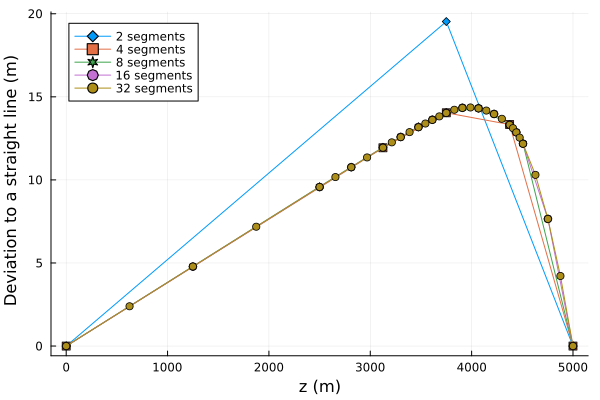

In [13]:
# We plot the distance of the points to x=y=z (equation of the line for the proposed source and receiver) for each Z

using Plots 

plot(legend=:topleft)

z2=Plot_Coords[1][:, 3]
aux2=sqrt.((Plot_Coords[1][:, 1]-Plot_Coords[1][:, 3]).^2+(Plot_Coords[1][:, 2]-Plot_Coords[1][:, 3]).^2)
plot!(z2,aux2, label="2 segments", shape=:diamond)

z4=Plot_Coords[2][:, 3]
aux4=sqrt.((Plot_Coords[2][:, 1]-Plot_Coords[2][:, 3]).^2+(Plot_Coords[2][:, 2]-Plot_Coords[2][:, 3]).^2)
plot!(z4,aux4, label="4 segments", shape=:square)

z8=Plot_Coords[3][:, 3]
aux8=sqrt.((Plot_Coords[3][:, 1]-Plot_Coords[3][:, 3]).^2+(Plot_Coords[3][:, 2]-Plot_Coords[3][:, 3]).^2)
plot!(z8,aux8, label="8 segments", shape=:star6)

z16=Plot_Coords[4][:, 3]
aux16=sqrt.((Plot_Coords[4][:, 1]-Plot_Coords[4][:, 3]).^2+(Plot_Coords[4][:, 2]-Plot_Coords[4][:, 3]).^2)
plot!(z16,aux16, label="16 segments", shape=:octagon)

z32=Plot_Coords[5][:, 3]
aux32=sqrt.((Plot_Coords[5][:, 1]-Plot_Coords[5][:, 3]).^2+(Plot_Coords[5][:, 2]-Plot_Coords[5][:, 3]).^2)
plot!(z32,aux32, label="32 segments", shape=:circle)

xlabel!("z (m)")
ylabel!(" Deviation to a straight line (m)")
#savefig("name.png")

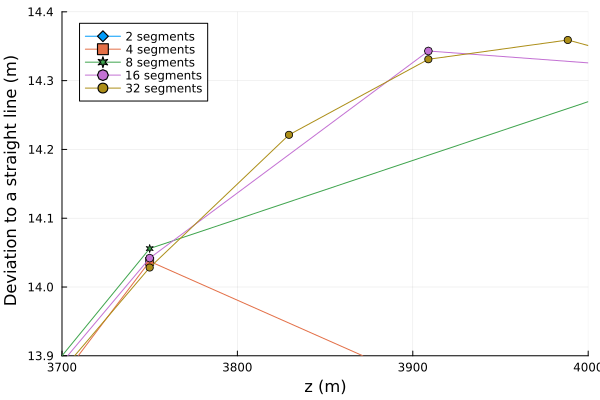

In [14]:
#We expand on the figure
using Plots 

plot(legend=:topleft)

z2=Plot_Coords[1][:, 3]
aux2=sqrt.((Plot_Coords[1][:, 1]-Plot_Coords[1][:, 3]).^2+(Plot_Coords[1][:, 2]-Plot_Coords[1][:, 3]).^2)
plot!(z2,aux2, label="2 segments", shape=:diamond)

z4=Plot_Coords[2][:, 3]
aux4=sqrt.((Plot_Coords[2][:, 1]-Plot_Coords[2][:, 3]).^2+(Plot_Coords[2][:, 2]-Plot_Coords[2][:, 3]).^2)
plot!(z4,aux4, label="4 segments", shape=:square)

z8=Plot_Coords[3][:, 3]
aux8=sqrt.((Plot_Coords[3][:, 1]-Plot_Coords[3][:, 3]).^2+(Plot_Coords[3][:, 2]-Plot_Coords[3][:, 3]).^2)
plot!(z8,aux8, label="8 segments", shape=:star6)

z16=Plot_Coords[4][:, 3]
aux16=sqrt.((Plot_Coords[4][:, 1]-Plot_Coords[4][:, 3]).^2+(Plot_Coords[4][:, 2]-Plot_Coords[4][:, 3]).^2)
plot!(z16,aux16, label="16 segments", shape=:octagon)

z32=Plot_Coords[5][:, 3]
aux32=sqrt.((Plot_Coords[5][:, 1]-Plot_Coords[5][:, 3]).^2+(Plot_Coords[5][:, 2]-Plot_Coords[5][:, 3]).^2)
plot!(z32,aux32, label="32 segments", shape=:circle)
xlims!(3700,4000)
ylims!(13.90,14.40)
xlabel!("z (m)")
ylabel!(" Deviation to a straight line (m)")
#savefig("name.png")

In [15]:
#Coordinates for 16 segments
Plot_Coords[4]

17×3 Matrix{Float64}:
    0.0      0.0      0.0
 1253.39  1253.39  1250.0
 2506.75  2506.75  2499.98
 2820.1   2820.1   2812.48
 3133.44  3133.44  3124.99
 3308.98  3308.98  3300.08
 3484.51  3484.51  3475.19
 3622.22  3622.22  3612.59
 3759.93  3759.93  3750.0
 3919.01  3919.01  3908.87
 4078.02  4078.02  4067.9
 4231.24  4231.24  4221.37
 4384.41  4384.41  4374.99
 4449.91  4449.91  4440.82
 4515.38  4515.38  4506.77
 4758.04  4758.04  4752.62
 5000.0   5000.0   5000.0